In [1]:
# python
import os
import sys
import importlib
# columnar analysis
from coffea import processor
from coffea.nanoevents import NanoAODSchema
import awkward as ak
from dask.distributed import Client, performance_report
# local
sidm_path = str(os.getcwd()).split("/sidm")[0]
if sidm_path not in sys.path: sys.path.insert(1, sidm_path)
from sidm.tools import utilities, sidm_processor, scaleout, llpnanoaodschema
# always reload local modules to pick up changes during development
importlib.reload(utilities)
importlib.reload(sidm_processor)
importlib.reload(scaleout)
# plotting
import matplotlib.pyplot as plt
utilities.set_plot_style()
%matplotlib inline
from hist import intervals
import coffea.util
# import numpy as np
import mplhep as hep
import numpy as np
import warnings

In [2]:
import yaml
yaml_file_path = '../../configs/ntuples/signal_2mu2e_v10.yaml'
# Open and read the YAML file
with open(yaml_file_path, 'r') as file:
    data = yaml.safe_load(file)
signals_all = list(data["llpNanoAOD_v2"]["samples"].keys())
# for x in range(len(signals_all)):
#     # if x == 0:
#     print("'" + signals_all[x] + "',")
    

In [3]:
QCD=[ 
     "QCD_Pt15To20", 
     "QCD_Pt20To30",
     "QCD_Pt30To50",
     "QCD_Pt50To80",
     "QCD_Pt80To120",
     "QCD_Pt120To170",
    "QCD_Pt170To300",
    "QCD_Pt300To470",
     "QCD_Pt470To600",
     "QCD_Pt600To800",
    "QCD_Pt800To1000",
     "QCD_Pt1000",
    ]
DY = [ 
    "DYJetsToMuMu_M10to50",
    "DYJetsToMuMu_M50",
     ]
TT = [ 
    "TTJets",
     ]

bgs=  TT + QCD + DY


def sum_bgs_hist(bgs_list, histogram_name, channel_name):
    """
    Sum histograms for a list of backgrounds.
    """
    summed_hist = None
    
    for x in bgs_list:
        # print(x)
        output_bg = coffea.util.load(f"output_{x}{channel_name}.coffea")
        hist = output_bg["out"][x]["hists"][histogram_name][channel_name, :]
        
        if summed_hist is None:
            summed_hist = hist.copy()
        else:
            summed_hist += hist
    
    return summed_hist



thresholds [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]


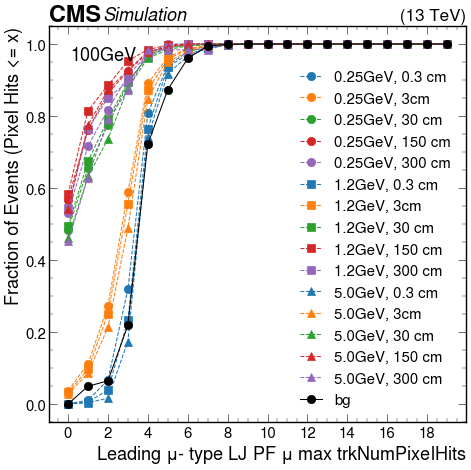

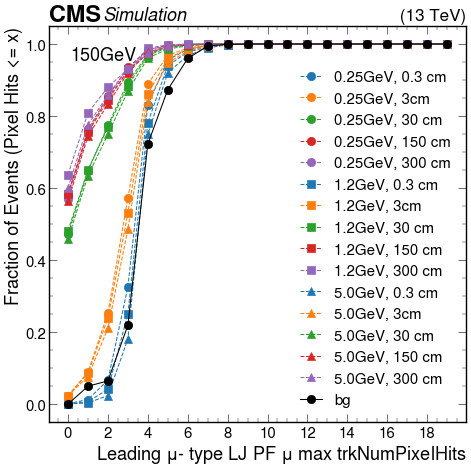

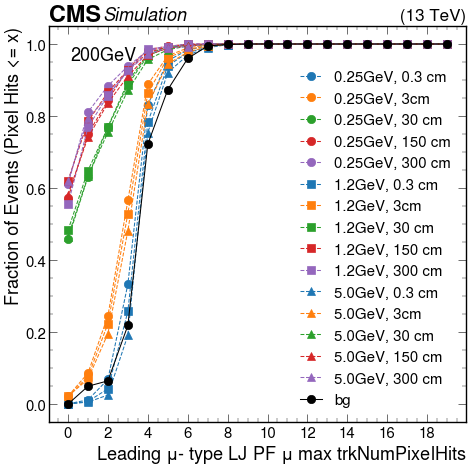

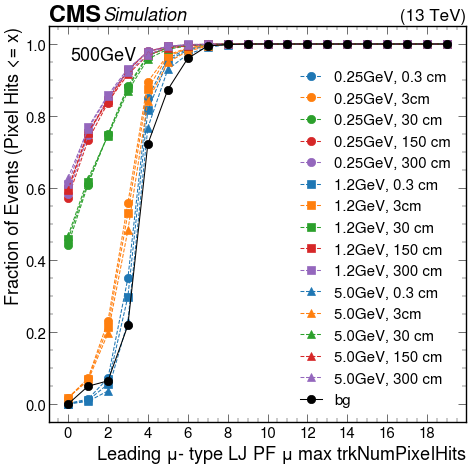

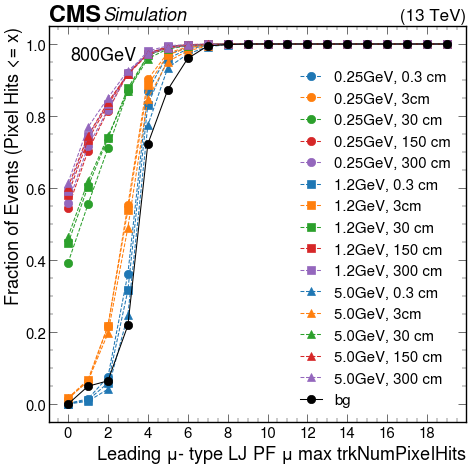

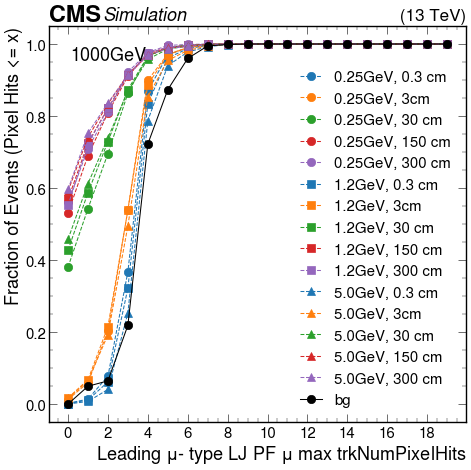

In [9]:
channel_name = "base_ljObjCut_ljIso_2lj"
output_signal = coffea.util.load(f"output_signal_{channel_name}.coffea" )
signals_per_plot = 15
n_signals = len(signals_all)
markers = ["o", "s", "^", "D", "v"]
colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd"]
thresholds = np.arange(0, 20, 1)
lxy = ["0.3 cm", "3cm", "30 cm", "150 cm", "300 cm"] 
print("thresholds", thresholds)
histogram_name = "leading_mu_lj_pfMu_max_trkNumPixelHits"

sum_bg = sum_bgs_hist(bgs, histogram_name, channel_name)
values_bg = sum_bg.values()
overflow_bg= sum_bg.values(flow=True)[-1]
underflow_bg= sum_bg.values(flow=True)[0]
n_events_bg =[]
bin_edges = sum_bg.axes[0].edges
total_bg = values_bg.sum() + overflow_bg + underflow_bg 

for t in thresholds:
    idx = np.searchsorted(bin_edges, t, side="right") -1 
    idx = max(idx, 0)  # avoid negative index 
    n_events_bg_thres = values_bg[:idx + 1].sum() + underflow_bg
    # print("thre", repr(t), idx, bin_edges[idx  ],n_events_bg_thres)
    n_events_bg.append(n_events_bg_thres)
fraction = np.array(n_events_bg)/total_bg


for i in range(0, n_signals, signals_per_plot):
    # plt.figure(figsize=(15, 12))
    subset = signals_all[i:i + signals_per_plot]

    for i, s in enumerate(subset):
        # print(s)
        marker = markers[i // 5 % len(colors)] 
        histogram = output_signal["out"][s]["hists"][histogram_name][channel_name, :]
        values = histogram.values()
        values_flow = histogram.values(flow=True)
        overflow = values_flow[-1]
        underflow = values_flow[0]
        bin_edges = histogram.axes[0].edges

        n_total = values_flow.sum()
        n_events = []

        for threshold in thresholds:
            idx = np.searchsorted(bin_edges, threshold, side="right") - 1
            idx = max(idx, 0)
            n_events_thres = values[:idx + 1].sum() + underflow
            n_events.append(n_events_thres)

        n_fraction = np.array(n_events) / n_total
        # signal_pass[s] = n_fraction
        parts = s.split("_")
        mass = parts[1]
        zd_mass = parts[2].replace("p", ".")
        ctau = parts[3].replace("p", ".").replace("mm", "")
        label =  zd_mass + ", " 
        plt.plot(thresholds, n_fraction, marker=marker, linestyle="--", label=label + lxy[i%5], color=colors[i%5], markersize=12)
    plt.plot(thresholds, fraction, marker="o", linestyle="-", label="bg", color = "k", markersize=12)

    plt.ylabel("Fraction of Events (Pixel Hits <= x)")
    plt.xlabel(r"Leading $\mu$- type LJ PF $\mu$ max trkNumPixelHits")
    plt.xticks(np.arange(0, 20, 2))
    hep.label.exp_text(text= mass, loc=3) 
    plt.legend()
    hep.cms.label()
    plt.style.use(hep.style.CMS)
    plt.tight_layout()
    if mass == "500GeV":
        plt.savefig("/home/cms-jovyan/SIDM/plots/" + histogram_name + mass + ".png", dpi=300)
    plt.show()
    plt.close()

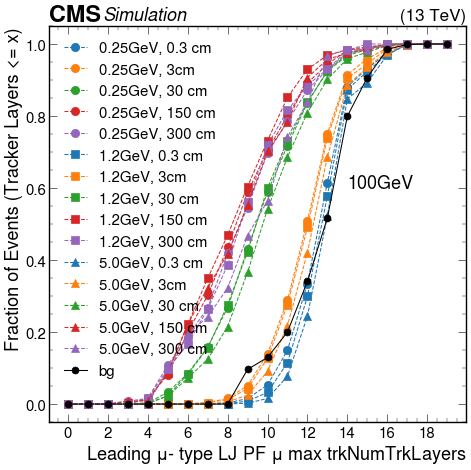

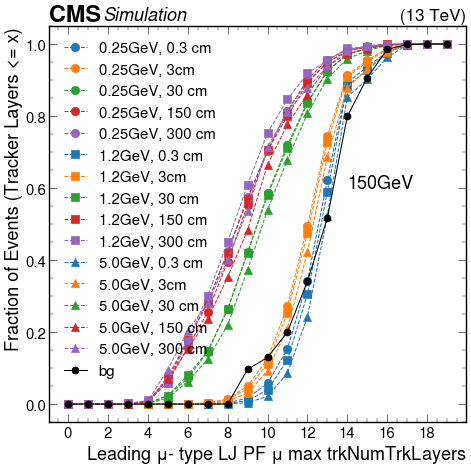

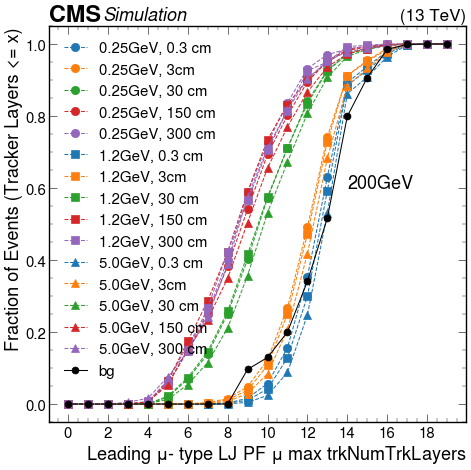

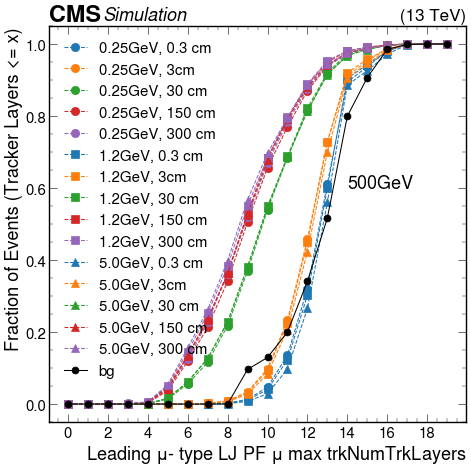

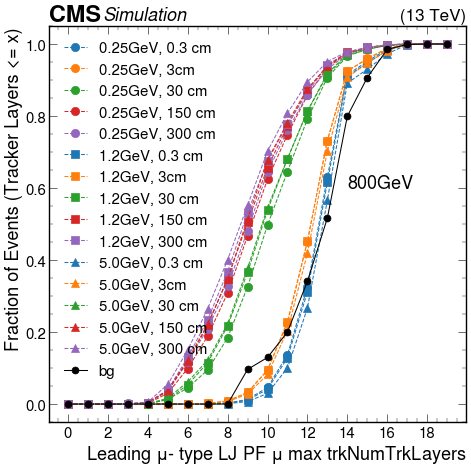

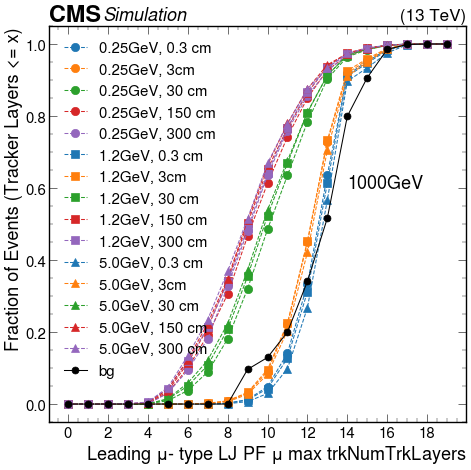

In [5]:

histogram_name = "leading_mu_lj_pfMu_max_trkNumTrkLayers"
thresholds = np.arange(0, 20, 1)
sum_bg = sum_bgs_hist(bgs, histogram_name, channel_name)
values_bg = sum_bg.values()
overflow_bg= sum_bg.values(flow=True)[-1]
underflow_bg= sum_bg.values(flow=True)[0]
n_events_bg =[]
bin_edges = sum_bg.axes[0].edges
total_bg = values_bg.sum() + overflow_bg + underflow_bg 

for t in thresholds:
    idx = np.searchsorted(bin_edges, t, side="right") -1 
    idx = max(idx, 0)  # avoid negative index 
    n_events_bg_thres = values_bg[:idx + 1].sum() + underflow_bg
    # print("thre", repr(t), idx, bin_edges[idx  ],n_events_bg_thres)
    n_events_bg.append(n_events_bg_thres)
fraction = np.array(n_events_bg)/total_bg


for i in range(0, n_signals, signals_per_plot):
    # plt.figure(figsize=(15, 12),)
    subset = signals_all[i:i + signals_per_plot]

    for i, s in enumerate(subset):
        # print(s)
        marker = markers[i // 5 % len(colors)] 
        histogram = output_signal["out"][s]["hists"][histogram_name][channel_name, :]
        values = histogram.values()
        values_flow = histogram.values(flow=True)
        overflow = values_flow[-1]
        underflow = values_flow[0]
        bin_edges = histogram.axes[0].edges

        n_total = values_flow.sum()
        n_events = []

        for threshold in thresholds:
            idx = np.searchsorted(bin_edges, threshold, side="right") - 1
            idx = max(idx, 0)
            n_events_thres = values[:idx + 1].sum() + underflow
            n_events.append(n_events_thres)

        n_fraction = np.array(n_events) / n_total
        # signal_pass[s] = n_fraction
        parts = s.split("_")
        mass = parts[1]
        zd_mass = parts[2].replace("p", ".")
        ctau = parts[3].replace("p", ".").replace("mm", "")
        label =  zd_mass + ", " 
        plt.plot(thresholds, n_fraction, marker=marker, linestyle="--", label=label + lxy[i%5], color=colors[i%5], markersize=12)
    plt.plot(thresholds, fraction, marker="o", linestyle="-", label="bg", color = "k", markersize=10)

    plt.ylabel("Fraction of Events (Tracker Layers <= x)")
    plt.xlabel(r"Leading $\mu$- type LJ PF $\mu$ max trkNumTrkLayers")
    plt.xticks(np.arange(0, 20, 2))
    # hep.label.exp_text(text= mass, loc=2) 
    # plt.ylim(0, 1.2)
    plt.text(14, 0.6, mass)
    plt.legend()
    hep.cms.label()
    plt.style.use(hep.style.CMS)
    plt.tight_layout()
    if mass == "500GeV":
        plt.savefig("/home/cms-jovyan/SIDM/plots/" + histogram_name + mass + ".png", dpi=300)
    plt.show()
    plt.close()

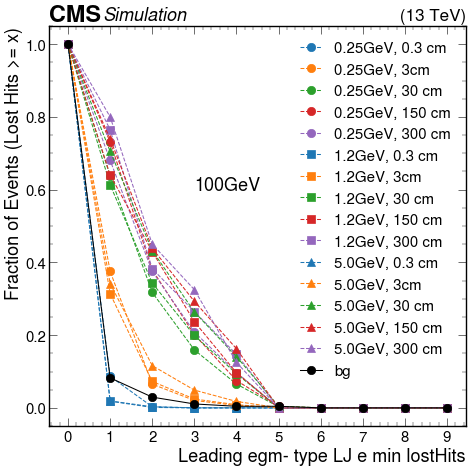

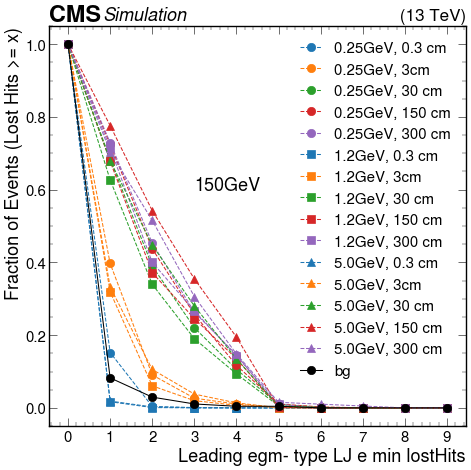

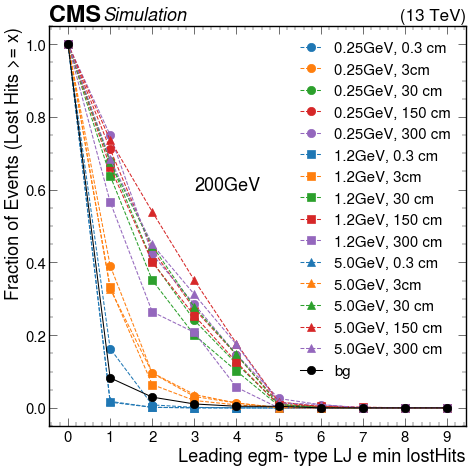

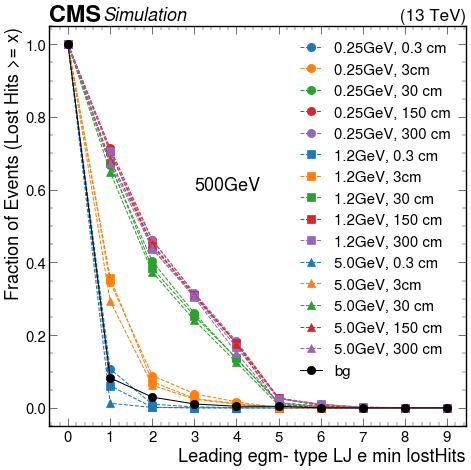

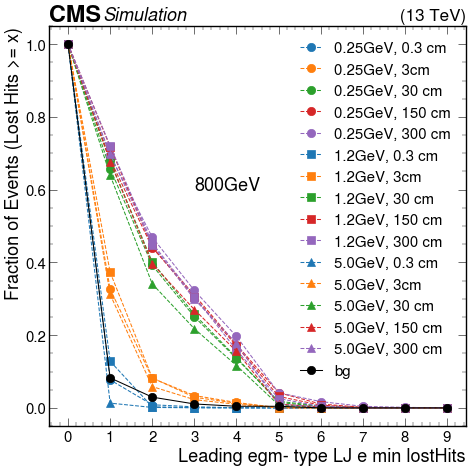

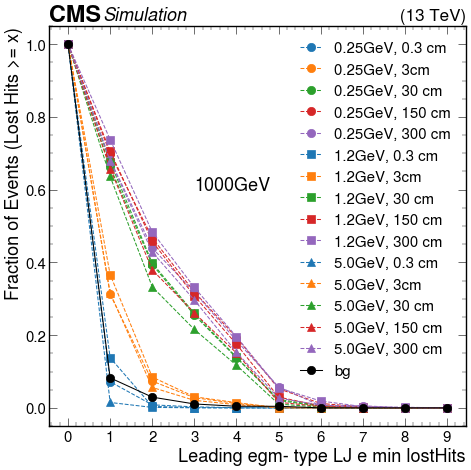

In [8]:

histogram_name = "leading_egm_lj_electron_min_lostHits"
thresholds = np.arange(0, 10, 1)

sum_bg = sum_bgs_hist(bgs, histogram_name, channel_name)
values_bg = sum_bg.values()
overflow_bg= sum_bg.values(flow=True)[-1]
underflow_bg= sum_bg.values(flow=True)[0]
n_events_bg =[]
bin_edges = sum_bg.axes[0].edges
total_bg = values_bg.sum() + overflow_bg + underflow_bg 

for t in thresholds:
    idx = np.searchsorted(bin_edges, t, side="right") -1 
    idx = max(idx, 0)  # avoid negative index 
    n_events_bg_thres = values_bg[idx:].sum() + overflow_bg
    # print("thre", repr(t), idx, bin_edges[idx  ],n_events_bg_thres)
    n_events_bg.append(n_events_bg_thres)
fraction = np.array(n_events_bg)/total_bg


for i in range(0, n_signals, signals_per_plot):
    # plt.figure(figsize=(15, 12))
    subset = signals_all[i:i + signals_per_plot]

    for i, s in enumerate(subset):
        # print(s)
        marker = markers[i // 5 % len(colors)] 
        histogram = output_signal["out"][s]["hists"][histogram_name][channel_name, :]
        values = histogram.values()
        values_flow = histogram.values(flow=True)
        overflow = values_flow[-1]
        underflow = values_flow[0]
        bin_edges = histogram.axes[0].edges

        n_total = values_flow.sum()
        n_events = []

        for threshold in thresholds:
            idx = np.searchsorted(bin_edges, threshold, side="right") - 1
            idx = max(idx, 0)
            n_events_thres = values[idx:].sum() + overflow
            n_events.append(n_events_thres)

        n_fraction = np.array(n_events) / n_total
        parts = s.split("_")
        mass = parts[1]
        zd_mass = parts[2].replace("p", ".")
        ctau = parts[3].replace("p", ".").replace("mm", "")
        label =  zd_mass + ", " 
        plt.plot(thresholds, n_fraction, marker=marker, linestyle="--", label=label + lxy[i%5], color=colors[i%5], markersize=12)
    plt.plot(thresholds, fraction, marker="o", linestyle="-", label="bg", color = "k", markersize=12)

    plt.ylabel("Fraction of Events (Lost Hits >= x)")
    plt.xlabel(r"Leading egm- type LJ e min lostHits")
    plt.xticks(np.arange(0, 10, 1))
    plt.text(3, 0.6, mass)
    plt.legend()
    hep.cms.label()
    plt.style.use(hep.style.CMS)
    plt.tight_layout()
    if mass == "500GeV":
        plt.savefig("/home/cms-jovyan/SIDM/plots/" + histogram_name + mass + ".png", dpi=300)
    plt.show()
    plt.close()